In [1]:
import tensorflow as tf
from tensorflow import keras

# Extra code so Juypter doesn't crash on mac os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from tensorflow.keras import layers
import numpy as np

In [3]:
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(32,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 6,922
Trainable params: 6,922
Non-trainable params: 0
_________________________________________________________________


## Eager Execution

In [4]:
# Makes tensorflow more like numpy. 
# Call operations directly vs making a computation graph

# tf.math operations converts python objects, or numpy arrays to tensors
x = [[2.]]
m = tf.matmul(x,x) 
# print(m)

x = np.ones((2,2))
m = tf.matmul(x,x) 
# print(m)

# use the .numpy() method to return tensor value as numpy array
m = m.numpy()
# print(m)

In [5]:
#define constant
a = tf.constant([[1, 2],[3, 4]])
# a = tf.Tensor([[1, 2],[3, 4]])
print(a)

# broadcasting

b = tf.add(a,1)
print(b)

# operator overloading

a = a + 1
print(b)
print(a * b)
print(tf.matmul(a,b))

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 4  9]
 [16 25]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[16 21]
 [28 37]], shape=(2, 2), dtype=int32)


In [6]:
# dynamic flow control

def dyn_function(x):
    
    counter = tf.constant(0)
    x = tf.constant(x)
    for i in range(1, x.numpy()+1):
        if i%2==0:
            print(x.numpy())
        elif i%5==0:
            x += 1
        else:
            continue
            
dyn_function(10)

10
10
11
11
11


In [7]:
# Gradient Tape

w = tf.Variable([[1.0]]) # as suppose to a constant
with tf.GradientTape(persistent=True) as tape:
    loss = w*w
    
grad = tape.gradient(loss,w)
print(grad)
try: 
    print(tape.gradient(loss,w))
except:
    print("You can only use a gradient tape once")
    
    

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [8]:
w = tf.constant([[1.0]]) # does not automatically track gradient for constant
with tf.GradientTape() as tape:
    loss = w*w
    
grad = tape.gradient(loss,w)
print(grad)

None


In [9]:
# Train a model

(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

mnist_images = mnist_images[:1000]
mnist_labels = mnist_labels[:1000]

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32, drop_remainder=True)

In [10]:
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [11]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())


Logits:  [[-0.00091014 -0.00527875 -0.00593279 -0.01145211 -0.00959605  0.01858576
   0.00415484  0.00820452  0.01311629 -0.01303012]]


In [12]:
x = tf.debugging.Assert(1==1,[2])
print(x)

None


In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [14]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        
        tf.debugging.assert_equal(logits.shape,(32,10))
        
        loss_value = loss_object(labels,logits)
        
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads,mnist_model.trainable_variables))
    

In [15]:
def train(epochs):
    for epoch in range(epochs):
        for (batch,(images,labels)) in enumerate(dataset):
            train_step(images, labels)
#             print(batch)
            
        print("Epoch {} finished".format(epoch))

In [16]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

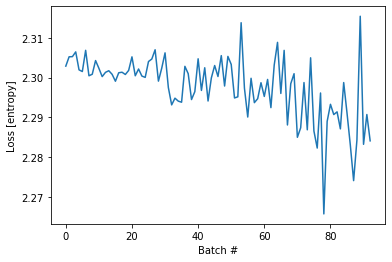

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [18]:
# Custom Model

class Linear(tf.keras.Model):
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5.,name="weight")
        self.B = tf.Variable(10.,name="bias")
    def call(self,inputs):
        return inputs * self.W + self.B

In [33]:
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

In [34]:
def loss(model,inputs,targets):
    error= model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value,[model.W, model.B])


In [35]:
# Create the Model

model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
steps = 300
for i in range(steps):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))



Initial loss: 70.254
Loss at step 000: 67.465
Loss at step 020: 30.218
Loss at step 040: 13.855
Loss at step 060: 6.663
Loss at step 080: 3.500
Loss at step 100: 2.108
Loss at step 120: 1.495
Loss at step 140: 1.225
Loss at step 160: 1.106
Loss at step 180: 1.053
Loss at step 200: 1.030
Loss at step 220: 1.020
Loss at step 240: 1.015
Loss at step 260: 1.013
Loss at step 280: 1.012


In [40]:
# With logging

logdir = "tb/train"
writer = tf.summary.create_file_writer(logdir)

In [42]:
for i in range(steps):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    loss_val = loss(model, training_inputs, training_outputs)
    with writer.as_default():
        tf.summary.scalar('loss',loss_val,step=i)
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss_val))


Loss at step 000: 1.012
Loss at step 020: 1.012
Loss at step 040: 1.012
Loss at step 060: 1.012
Loss at step 080: 1.012
Loss at step 100: 1.012
Loss at step 120: 1.012
Loss at step 140: 1.012
Loss at step 160: 1.012
Loss at step 180: 1.012
Loss at step 200: 1.012
Loss at step 220: 1.012
Loss at step 240: 1.012
Loss at step 260: 1.012
Loss at step 280: 1.012


## Variables

In [56]:
v = tf.Variable(0)
print(v)
print(v.read_value())
w = v + 1
print(w)
try:
    print(w.read_value())
except:
    print("W is no longer a variable")

v.assign(2)
print(v.read_value())

v.assign_add(2)
print(v.read_value())


<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
W is no longer a variable
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


## Memory Gradient Test

In [ ]:
memory = []


In [111]:
x = tf.Variable(tf.ones([3,1]))
W = tf.Variable(np.random.random((3,3)),dtype="float32")

print(W.read_value())
print(x_test.read_value())

def model(x):
    return tf.matmul(W, x)

with tf.GradientTape() as tape:
    a = model(x)
    b = model(a)

#     print(y_1)
    
grads = tape.gradient(b,W)
print(grads)

print("Calculated Grads")
print(grads[0,0].numpy())
print("Grad W_11")
print("One pass: ", x.numpy()[0,0])
print("Loop pass: ", a.numpy()[0,0] + np.sum(W.numpy()[:,0]*x.numpy()[0,0]))
val = a[0,0] + tf.reduce_sum(W[:,0]*x[0,0])
print("Loop pass (w/ tensors): ", val.numpy())

tf.Tensor(
[[0.8953123  0.78257275 0.47685826]
 [0.05573949 0.6391835  0.5740697 ]
 [0.58783084 0.08771657 0.9548248 ]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[3.693626  2.8078752 3.1692548]
 [3.664216  2.7784655 3.1398451]
 [4.1604958 3.2747452 3.6361248]], shape=(3, 3), dtype=float32)
Calculated Grads
3.693626
Grad W_11
One pass:  1.0
Loop pass:  3.693626
Loop pass (w/ tensors):  3.693626
